<a href="https://colab.research.google.com/github/Eddy-Emmanuel/Moon-Segmentation-UNET/blob/main/Moon_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'artificial-lunar-rocky-landscape-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F202982%2F489236%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240417%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240417T195624Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5757645d60d49227fb221da2e7d04a1bcd6e308113d7659de56def3c17c61cf2b423cf21e34a86497de882d4321b9e5ebc52e0b2a968c64ae7044b7547bf0e52f05592a944171b91775330aca5b23b39994d93dd2d456d473e501a5a4df38839b4ff7bed235c1c084cfaea4d8b23b8d93f2ed22d797e8422dde14579a76e5c19f4ef29b560984966f731738a55a7f0af00fd41d9c5eaa3fef7673d6d998b7b77e7fda6bf37088fe0ba953bb2b052f498bc50f211dc94f924a21bc6c49ed4f84d1e82aa280ee33138fba3ec5b0100116f429d4dbb3819e3be66ac40405ff6e76f5718338c17b5b311c519324788cd9365295e15524f199df23e1cdc873845f702'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import os
import numpy as np
import pandas as pd
from glob import glob

import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2, MobileNetV2
from tensorflow.keras import Input, layers, Model, optimizers, losses

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

2024-04-17 19:49:00.642131: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 19:49:00.642231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 19:49:00.785016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
mask_path = sorted(glob(pathname="/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/*ground/*"))[:101]
image_path = sorted(glob(pathname="/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/*render/*"))[:101]

print(f'Mask Path Length: {len(mask_path)}, Image Path Length: {len(image_path)}')

Mask Path Length: 101, Image Path Length: 101


In [ ]:
data = pd.DataFrame({
                    "image": image_path,
                    "mask": mask_path
                })

data.head()

,image,mask
0,/kaggle/input/artificial-lunar-rocky-landscape...,/kaggle/input/artificial-lunar-rocky-landscape...
1,/kaggle/input/artificial-lunar-rocky-landscape...,/kaggle/input/artificial-lunar-rocky-landscape...
2,/kaggle/input/artificial-lunar-rocky-landscape...,/kaggle/input/artificial-lunar-rocky-landscape...
3,/kaggle/input/artificial-lunar-rocky-landscape...,/kaggle/input/artificial-lunar-rocky-landscape...
4,/kaggle/input/artificial-lunar-rocky-landscape...,/kaggle/input/artificial-lunar-rocky-landscape...


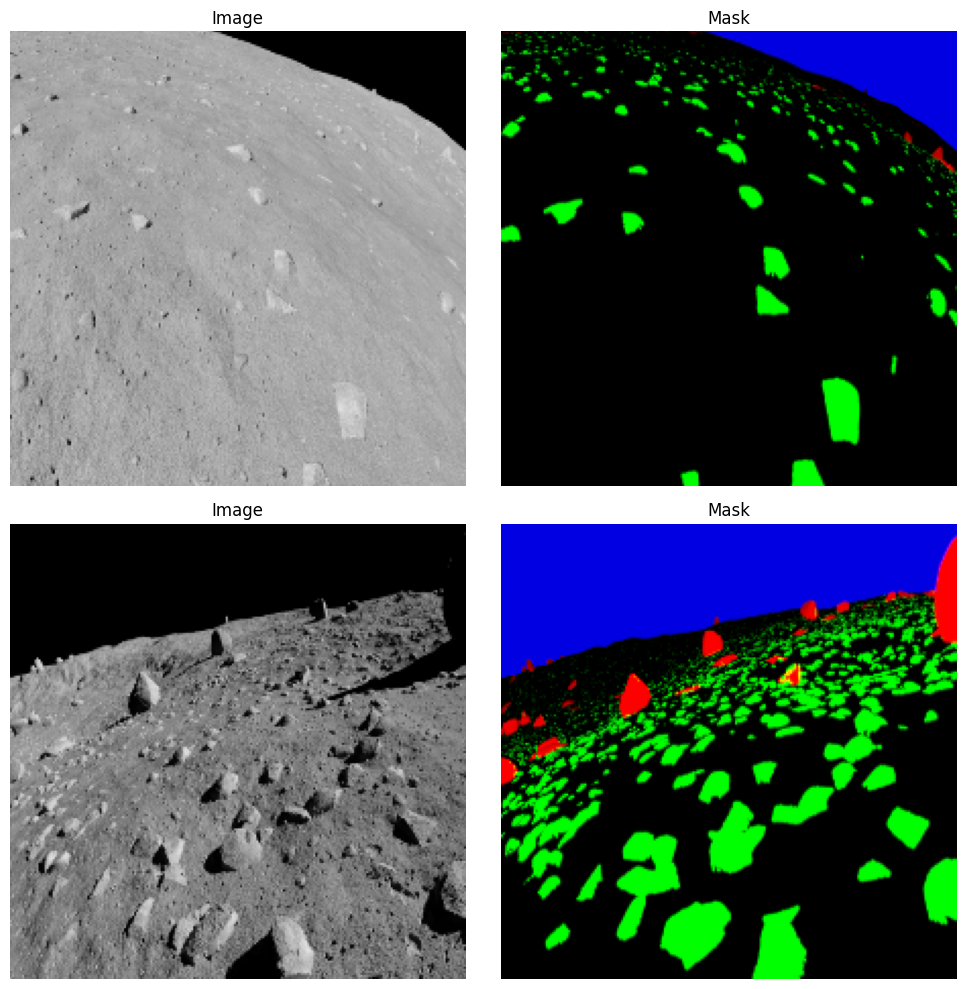

In [ ]:
random_image_index = np.random.randint(low=0, high=data.shape[0], size=2)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i, img_idx in enumerate(random_image_index):
    img_row = data.iloc[img_idx]
    img = img_row["image"]
    mask = img_row["mask"]

    loaded_img = cv2.resize(cv2.cvtColor(cv2.imread(img), 0), (224, 224))/255
    loaded_msk = cv2.resize(cv2.cvtColor(cv2.imread(mask), 0), (224, 224))/255

    ax[i, 0].imshow(loaded_img, cmap="gray")
    ax[i, 0].set_title('Image')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(loaded_msk, cmap="gray")
    ax[i, 1].set_title('Mask')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Checking for number of unique values in the mask
print(np.unique(cv2.cvtColor(cv2.imread(data["mask"][4]), cv2.COLOR_BGR2RGB)))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [ ]:
train_img, test_img = train_test_split(data, train_size=.8, random_state=42)
test_img, val_img = train_test_split(test_img, train_size=.8, random_state=42)

print(train_img.shape, test_img.shape, val_img.shape)

(80, 2) (16, 2) (5, 2)


In [ ]:
def standard_scaler(x):
    x_copy = x.copy()
    scaler = StandardScaler()
    reshaped_copy = x_copy.reshape(-1, x.shape[-1])
    scaled_copy = scaler.fit_transform(reshaped_copy)
    return scaled_copy.reshape(x.shape)

def min_max_scaler(x):
    x_copy = x.copy()
    scaler = MinMaxScaler()
    reshaped_copy = x_copy.reshape(-1, x.shape[-1])
    scaled_copy = scaler.fit_transform(reshaped_copy)
    return scaled_copy.reshape(x.shape)

def encode_mask(y):
    y_copy = y.copy()
    encoder = LabelEncoder()
    reshaped_copy = y_copy.reshape(-1, 1)
    unique_classes = np.unique(reshaped_copy)
    encoder.fit(unique_classes)
    encoded_y = encoder.transform(reshaped_copy)
    return encoded_y.reshape(y.shape)

def DataGenerator(X: pd.DataFrame, batch_size: int = 32, scale=None, normalize=None, encode_msk=None):
    image_read = lambda x: img_to_array(load_img(x, target_size=(128, 128), color_mode="rgb"))

    image_paths = X["image"].tolist()
    mask_paths = X["mask"].tolist()

    num_samples = len(image_paths)
    steps_per_epoch = num_samples // batch_size

    for step in range(steps_per_epoch):
        """
        Iteration 1: start_index = 0*32, end_index = (0+1)*32
        Iteration 2: start_index = 1*32, end_index = (1+1)*32
        Iteration 3: start_index = 2*32, end_index = (2+1)*32
        """
        start_index = step * batch_size
        end_index = (step + 1) * batch_size

        batch_images = np.array([image_read(path) for path in image_paths[start_index:end_index]])
        batch_masks = np.array([image_read(path) for path in mask_paths[start_index:end_index]])

        # Preprocessing options
        if encode_msk:
            # print("Encode == True")
            batch_masks = np.array([encode_mask(mask) for mask in batch_masks])

        if scale:
            # print("Scale == True")
            batch_images = np.array([standard_scaler(image) for image in batch_images])
            batch_masks = np.array([standard_scaler(mask) for mask in batch_masks])

        if normalize:
            # print("Normalize == True")
            batch_images = np.array([min_max_scaler(image) for image in batch_images])
            batch_masks = np.array([min_max_scaler(mask) for mask in batch_masks])

        yield batch_images, batch_masks

In [ ]:
image_batch, mask_batch = next(DataGenerator(X=train_img, batch_size=32, scale=True, encode_msk=True))

print(image_batch.shape, mask_batch.shape)

(32, 128, 128, 3) (32, 128, 128, 3)


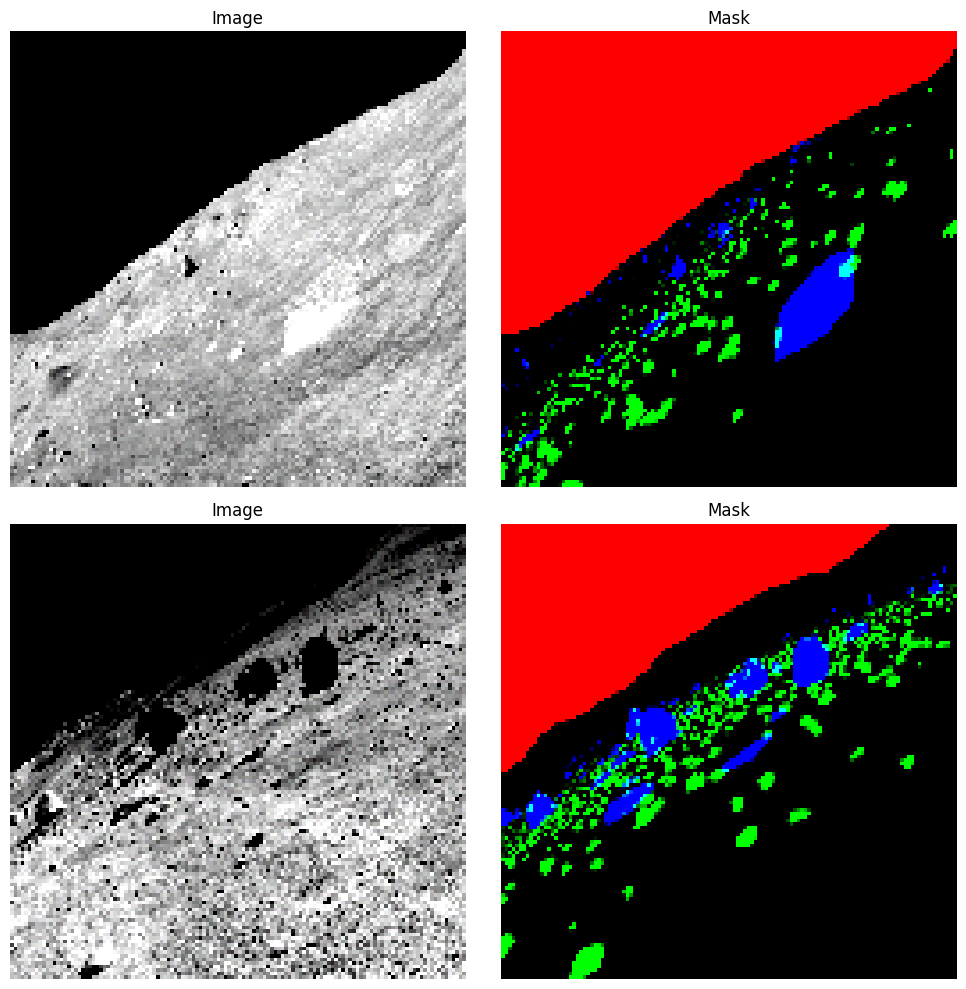

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for idx, (i, j) in enumerate(zip(image_batch, mask_batch), start=0):
    ax[idx, 0].imshow(i)
    ax[idx, 0].set_title('Image')
    ax[idx, 0].axis('off')

    ax[idx, 1].imshow(j)
    ax[idx, 1].set_title('Mask')
    ax[idx, 1].axis('off')

    if idx == 1:
        break

plt.tight_layout()
plt.show()

## Modelling (UNET)

In [ ]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))

base_model.trainable = False

base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
def Build_Unet():
    needed_layers = [base_model.get_layer(base_model.layers[0].name).output] + [base_model.get_layer(i).output for i in ["block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu", "block_13_expand_relu", "out_relu"]]

    up1 = layers.Conv2DTranspose(filters=1280, kernel_size=(2, 2), strides=(2, 2), padding="same", activation="relu")(needed_layers[-1])
    c1 = layers.concatenate([up1, needed_layers[-2]])
    conv1 = layers.Conv2D(filters=1280, kernel_size=(2, 2), padding="same", activation="relu")(c1)
    conv1 = layers.Conv2D(filters=1280, kernel_size=(3, 3), padding="same", activation="relu")(conv1)
    bn1 = layers.BatchNormalization()(conv1)

    up2 = layers.Conv2DTranspose(filters=1280, kernel_size=(2, 2), strides=(2, 2), padding="same", activation="relu")(bn1)
    c2 = layers.concatenate([up2, needed_layers[-3]])
    conv2 = layers.Conv2D(filters=1280, kernel_size=(2, 2), padding="same", activation="relu")(c2)
    conv2 = layers.Conv2D(filters=1280, kernel_size=(3, 3), padding="same", activation="relu")(conv2)
    bn2 = layers.BatchNormalization()(conv2)

    up3 = layers.Conv2DTranspose(filters=1280, kernel_size=(2, 2), strides=(2, 2), padding="same", activation="relu")(bn2)
    c3 = layers.concatenate([up3, needed_layers[-4]])
    conv3 = layers.Conv2D(filters=1280, kernel_size=(2, 2), padding="same", activation="relu")(c3)
    conv3 = layers.Conv2D(filters=1280, kernel_size=(3, 3), padding="same", activation="relu")(conv3)
    bn3 = layers.BatchNormalization()(conv3)

    up4 = layers.Conv2DTranspose(filters=1280, kernel_size=(2, 2), strides=(2, 2), padding="same", activation="relu")(bn3)
    c4 = layers.concatenate([up4, needed_layers[-5]])
    conv4 = layers.Conv2D(filters=1280, kernel_size=(2, 2), padding="same", activation="relu")(c4)
    conv4 = layers.Conv2D(filters=1280, kernel_size=(3, 3), padding="same", activation="relu")(conv4)
    bn4 = layers.BatchNormalization()(conv4)

    up5 = layers.Conv2DTranspose(filters=1280, kernel_size=(2, 2), strides=(2, 2), padding="same", activation="relu")(bn4)
    c5 = layers.concatenate([up5, needed_layers[-6]])
    conv5 = layers.Conv2D(filters=1280, kernel_size=(2, 2), padding="same", activation="relu")(c5)
    conv5 = layers.Conv2D(filters=1280, kernel_size=(3, 3), padding="same", activation="relu")(conv5)
    bn5 = layers.BatchNormalization()(conv5)

    output_layer = layers.Conv2D(filters=3, kernel_size=(2, 2), strides=(1, 1), padding="same", activation="softmax")(bn5)

    model = Model(inputs=base_model.input, outputs=output_layer)

    return model

In [ ]:
UNET = Build_Unet()

UNET.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 146,758,467 (559.84 MB)

 Trainable params: 144,487,683 (551.18 MB)

 Non-trainable params: 2,270,784 (8.66 MB)

In [ ]:
UNET.compile(optimizer=optimizers.AdamW(),
             loss=losses.CategoricalCrossentropy(),
             metrics=["accuracy"])

In [ ]:
TRAIN_GEN = ImageDataGenerator(horizontal_flip=True,
                               vertical_flip=True,
                               preprocessing_function=mobilenet_v2.preprocess_input)

VAL_GEN = ImageDataGenerator()

In [ ]:
history = UNET.fit(DataGenerator(X=train_img, batch_size=32, scale=True, encode_msk=True),
                   validation_data=DataGenerator(X=test_img, batch_size=32, scale=True, encode_msk=True),
                   epochs=20)

Epoch 1/20


2024-04-17 19:50:16.268141: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[32,1280,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1376,65,65]{3,2,1,0}, f32[1280,1376,2,2]{3,2,1,0}, f32[1280]{0}), window={size=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-17 19:50:16.290994: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.022961166s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[32,1280,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1376,65,65]{3,2,1,0}, f32[1280,1376,2,2]{3,2,1,0}, f32[1280]{0}), window={size=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a wh

## Conclusion:
* Due to lack of computation, training process has been suspended.

## Eddy